In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import netCDF4 as nc
import datetime as dt
from salishsea_tools import evaltools as et, viz_tools
import gsw
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import matplotlib.dates as mdates
import cmocean as cmo
import scipy.interpolate as sinterp
import pickle
import cmocean
import json
import f90nml
from collections import OrderedDict
import os
from matplotlib.colors import LogNorm

fs=16
mpl.rc('xtick', labelsize=fs)
mpl.rc('ytick', labelsize=fs)
mpl.rc('legend', fontsize=fs)
mpl.rc('axes', titlesize=fs)
mpl.rc('axes', labelsize=fs)
mpl.rc('figure', titlesize=fs)
mpl.rc('font', size=fs)
mpl.rc('text', usetex=True)
mpl.rc('text.latex', preamble = r'''
 \usepackage{txfonts}
 \usepackage{lmodern}
 ''')
mpl.rc('font', family='sans-serif', weight='normal', style='normal')

import warnings
warnings.filterwarnings('ignore')
from IPython.display import Markdown, display

%matplotlib inline

In [2]:
modver = '202007C-P2'
matchpath = '/data/sallen/results/MEOPAR/202007/202007C-p2/'
year='2015'
fnames = ('ObsModel_202007Cp2_TS_20150101-20150331.csv',
          'ObsModel_202007Cp2_TS_20150401-20150630.csv',
          'ObsModel_202007Cp2_TS_20150701-20150930.csv',
          'ObsModel_202007Cp2_TS_20151001-20151231.csv')

In [3]:
display(Markdown('''### DFO TS Comparisons '''))
display(Markdown('''###   ''' + modver))
display(Markdown('''###    '''+ str(year)))
display(Markdown('''### Files: \n'''+ '\n\n'.join(fnames)))

### DFO TS Comparisons 

###   202007C-P2

###    2015

### Files: 
ObsModel_202007Cp2_TS_20150101-20150331.csv

ObsModel_202007Cp2_TS_20150401-20150630.csv

ObsModel_202007Cp2_TS_20150701-20150930.csv

ObsModel_202007Cp2_TS_20151001-20151231.csv

In [4]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>

<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [5]:
data=list()
for ifile in fnames:
    data.append(pd.read_csv(os.path.join(matchpath,ifile),index_col=0))
data=pd.concat(data,ignore_index=True)
data.dropna(axis=1,how='all',inplace=True)
data['dtUTC']=[dt.datetime.strptime(ii,'%Y-%m-%d %H:%M:%S') for ii in data['dtUTC']]

In [6]:
print('Fields available:')
print([el for el in data.keys()])

Fields available:
['Year', 'Month', 'Day', 'Hour', 'Lat', 'Lon', 'Z', 'SA', 'CT', 'dtUTC', 'j', 'i', 'mod_vosaline', 'mod_votemper', 'k']


In [7]:
# density calculations:
data['rho']=gsw.rho(data['SA'],data['CT'],gsw.p_from_z(-1*data['Z'],data['Lat']))
data['mod_rho']=gsw.rho(data['mod_vosaline'],data['mod_votemper'],
                        gsw.p_from_z(-1*data['Z'],data['Lat']))

In [8]:
# load chl to N ratio from namelist
mod_chl_N=1.8
#start_date=np.min(data['dtUTC'])
#end_date=np.max(data['dtUTC'])

In [9]:
cm1=cmocean.cm.thermal
year=data.dtUTC[0].year
theta=-30
lon0=-123.9
lat0=49.3
with nc.Dataset('/data/eolson/results/MEOPAR/NEMO-forcing-new/grid/bathymetry_201702.nc') as bathy:
    bathylon=np.copy(bathy.variables['nav_lon'][:,:])
    bathylat=np.copy(bathy.variables['nav_lat'][:,:])
    bathyZ=np.copy(bathy.variables['Bathymetry'][:,:])

In [10]:
def byDepth(ax,obsvar,modvar,lims):
    ps=et.varvarPlot(ax,data,obsvar,modvar,'Z',(15,22),'z','m',('mediumseagreen','darkturquoise','navy'))
    l=ax.legend(handles=ps)
    ax.set_xlabel('Obs')
    ax.set_ylabel('Model')
    ax.plot(lims,lims,'k-',alpha=.5)
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_aspect(1)
    return ps,l

def byRegion(ax,obsvar,modvar,lims):
    ps1=et.varvarPlot(ax,dJDF,obsvar,modvar,cols=('b',),lname='SJDF')
    ps2=et.varvarPlot(ax,dSJGI,obsvar,modvar,cols=('c',),lname='SJGI')
    ps3=et.varvarPlot(ax,dSOG,obsvar,modvar,cols=('y',),lname='SOG')
    ps4=et.varvarPlot(ax,dNSOG,obsvar,modvar,cols=('m',),lname='NSOG')
    l=ax.legend(handles=[ps1[0][0],ps2[0][0],ps3[0][0],ps4[0][0]])
    ax.set_xlabel('Obs')
    ax.set_ylabel('Model')
    ax.plot(lims,lims,'k-',alpha=.5)
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_aspect(1)
    return (ps1,ps2,ps3,ps4),l

def bySeason(ax,obsvar,modvar,lims):
    for axi in ax:
        axi.plot(lims,lims,'k-')
        axi.set_xlim(lims)
        axi.set_ylim(lims)
        axi.set_aspect(1)
        axi.set_xlabel('Obs')
        axi.set_ylabel('Model')
    ps=et.varvarPlot(ax[0],JFM,obsvar,modvar,cols=('crimson','darkturquoise','navy'))
    ax[0].set_title('Jan-Mar')
    ps=et.varvarPlot(ax[1],Apr,obsvar,modvar,cols=('crimson','darkturquoise','navy'))
    ax[1].set_title('Apr')
    ps=et.varvarPlot(ax[2],MJJA,obsvar,modvar,cols=('crimson','darkturquoise','navy'))
    ax[2].set_title('May-Aug')
    ps=et.varvarPlot(ax[3],SOND,obsvar,modvar,cols=('crimson','darkturquoise','navy'))
    ax[3].set_title('Sep-Dec')
    return 

def densPlot(fig,ax,obsvar,modvar,lims=None):
    iii=(~np.isnan(data[obsvar]))&(~np.isnan(data[modvar]))
    counts, xedges, yedges, m1=ax.hist2d(data.loc[iii,[obsvar]].values.flatten(),
                                          data.loc[iii,[modvar]].values.flatten(),bins=25*3,norm=LogNorm())
    cb=fig.colorbar(m1,ax=ax)
    cb.ax.set_title('Count')
    if lims is not None:
        ax.set_xlim(lims)
        ax.set_ylim(lims)
        ax.plot(lims,lims,'k-',alpha=.5)
    ax.set_aspect(1)
    ax.set_xlabel('Obs')
    ax.set_ylabel('Model')
    return m1,cb

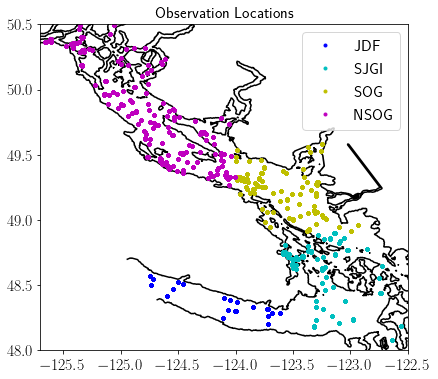

In [11]:
fig, ax = plt.subplots(1,1,figsize = (13,6))

viz_tools.set_aspect(ax, coords = 'map')
dJDF=data.loc[(data.Lon<-123.3)&(data.Lat<48.6)]
ax.plot(dJDF['Lon'],dJDF['Lat'],'b.',label='JDF')
dSJGI=data.loc[(data.Lon>=-123.6)&(data.Lat<48.9)]
ax.plot(dSJGI['Lon'],dSJGI['Lat'],'c.',label='SJGI')
dSOG=data.loc[(data.Lat>=48.9)&(data.Lon>-124.0)]
ax.plot(dSOG['Lon'],dSOG['Lat'],'y.',label='SOG')
dNSOG=data.loc[(data.Lat>=48.9)&(data.Lon<=-124.0)]
ax.plot(dNSOG['Lon'],dNSOG['Lat'],'m.',label='NSOG')
grid = nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc')
viz_tools.plot_coastline(ax, grid, coords = 'map')
ax.set_ylim(48, 50.5)
ax.legend()
ax.set_xlim(-125.7, -122.5);
ax.set_title('Observation Locations');

# Also set up seasonal groupings:
iz=(data.Z<15)
JFM=data.loc[iz&(data.dtUTC<=dt.datetime(year,4,1)),:]
Apr=data.loc[iz&(data.dtUTC<=dt.datetime(year,5,1))&(data.dtUTC>dt.datetime(year,4,1)),:]
MJJA=data.loc[iz&(data.dtUTC<=dt.datetime(year,9,1))&(data.dtUTC>dt.datetime(year,5,1)),:]
SOND=data.loc[iz&(data.dtUTC>dt.datetime(year,9,1)),:]

In [12]:
statsubs=OrderedDict({'z < 15 m':data.loc[data.Z<15],
                      '15 m < z < 22 m':data.loc[(data.Z>=15)&(data.Z<22)],
                      'z >= 22 m':data.loc[data.Z>=22],
                      'z > 50 m':data.loc[data.Z>50],
                      'all':data,
                      'z < 15 m, JFM':JFM,
                      'z < 15 m, Apr':Apr,
                      'z < 15 m, MJJA':MJJA,
                      'z < 15 m, SOND': SOND,
                      'SJDF':dJDF,
                      'SJGI':dSJGI,
                      'SOG':dSOG,
                      'NSOG':dNSOG})

## Conservative Temperature 

In [13]:
obsvar='CT'
modvar='mod_votemper'
statsDict={year:dict()}
statsDict[year]['Temperature']=OrderedDict()
for isub in statsubs:
    statsDict[year]['Temperature'][isub]=dict()
    var=statsDict[year]['Temperature'][isub]
    var['N'],mmean,omean,var['Bias'],var['RMSE'],var['WSS']=et.stats(statsubs[isub].loc[:,[obsvar]],
                                                                     statsubs[isub].loc[:,[modvar]])
tbl,tdf=et.displayStats(statsDict[year]['Temperature'],level='Subset',suborder=list(statsubs.keys()))
tbl

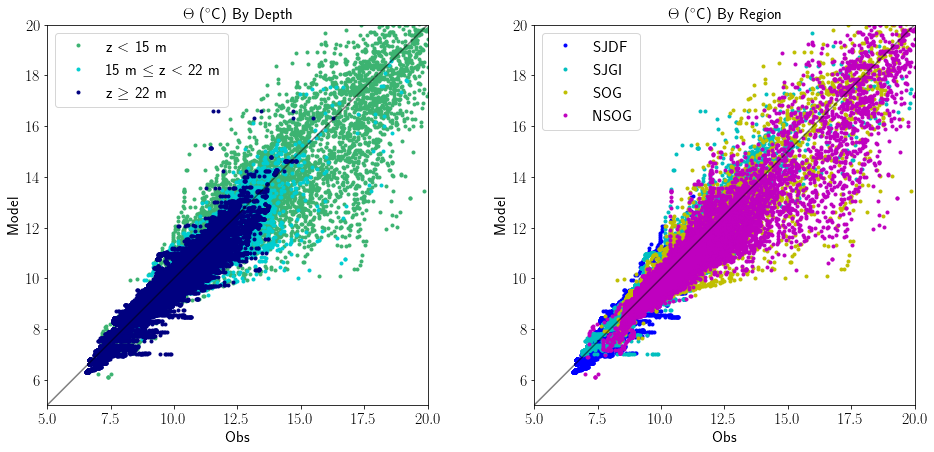

In [14]:
fig, ax = plt.subplots(1,2,figsize = (16,7))
ps,l=byDepth(ax[0],obsvar,modvar,(5,20))
ax[0].set_title('$\Theta$ ($^{\circ}$C) By Depth')

ps,l=byRegion(ax[1],obsvar,modvar,(5,20))
ax[1].set_title('$\Theta$ ($^{\circ}$C) By Region');

Text(0.5, 1.0, '$\\Theta$ ($^{\\circ}$C)')

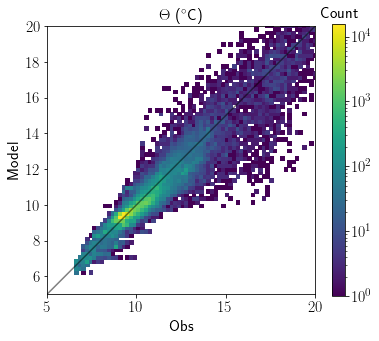

In [15]:
fig, ax = plt.subplots(1,1,figsize = (6,5))
a,b= densPlot(fig,ax,obsvar,modvar,(5,20))
ax.set_title('$\Theta$ ($^{\circ}$C)')

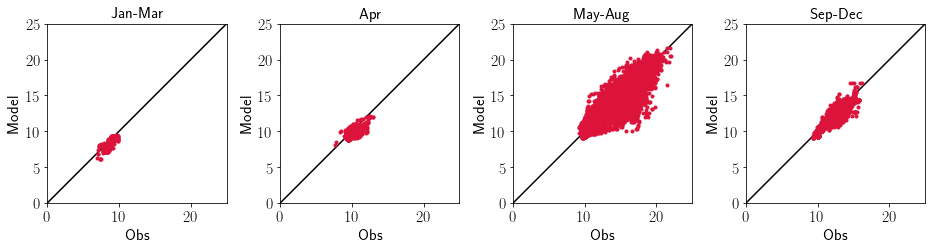

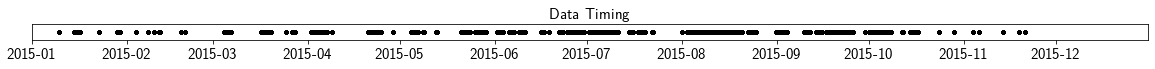

In [16]:
mv=(0,25)
fig, ax = plt.subplots(1,4,figsize = (16,3.3))
bySeason(ax,obsvar,modvar,mv)
fig,ax=plt.subplots(1,1,figsize=(20,.3))
ax.plot(data.dtUTC,np.ones(np.shape(data.dtUTC)),'k.')
ax.set_xlim((dt.datetime(year,1,1),dt.datetime(year,12,31)))
ax.set_title('Data Timing')
ax.yaxis.set_visible(False)

## Reference Salinity

In [17]:
obsvar='SA'
modvar='mod_vosaline'
statsDict[year]['Salinity']=OrderedDict()
for isub in statsubs:
    statsDict[year]['Salinity'][isub]=dict()
    var=statsDict[year]['Salinity'][isub]
    var['N'],mmean,omean,var['Bias'],var['RMSE'],var['WSS']=et.stats(statsubs[isub].loc[:,[obsvar]],
                                                                     statsubs[isub].loc[:,[modvar]])
tbl,tdf=et.displayStats(statsDict[year]['Salinity'],level='Subset',suborder=list(statsubs.keys()))
tbl

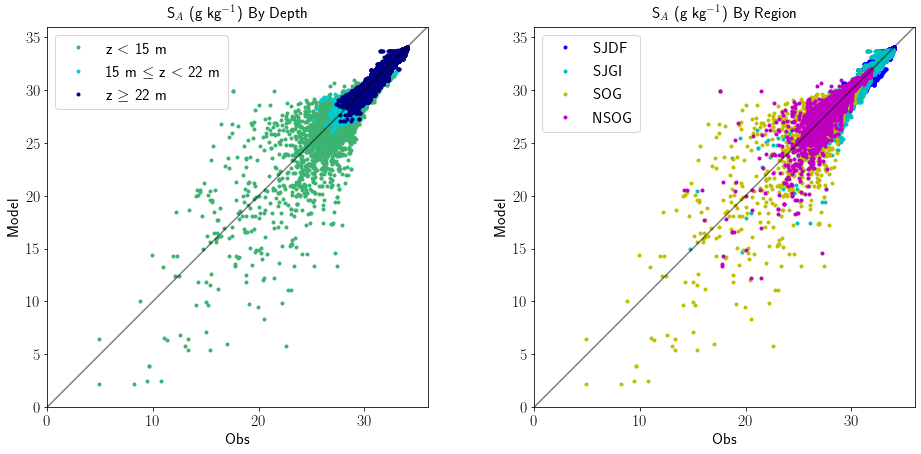

In [18]:
fig, ax = plt.subplots(1,2,figsize = (16,7))
ps,l=byDepth(ax[0],obsvar,modvar,(0,36))
ax[0].set_title('S$_A$ (g kg$^{-1}$) By Depth')

ps,l=byRegion(ax[1],obsvar,modvar,(0,36))
ax[1].set_title('S$_A$ (g kg$^{-1}$) By Region');

Text(0.5, 1.0, 'S$_A$ (g kg$^{-1}$)')

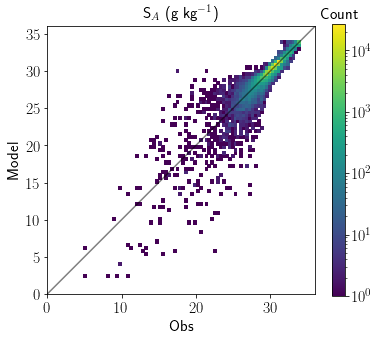

In [19]:
fig, ax = plt.subplots(1,1,figsize = (6,5))
a,b= densPlot(fig,ax,obsvar,modvar,(0,36))
ax.set_title('S$_A$ (g kg$^{-1}$)')

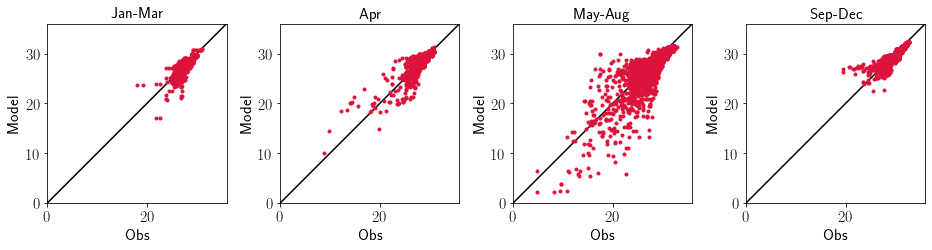

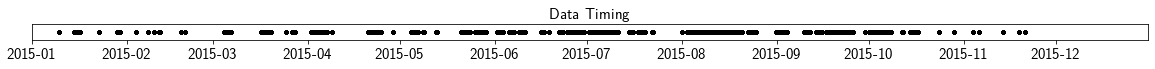

In [20]:
fig, ax = plt.subplots(1,4,figsize = (16,3.3))
bySeason(ax,obsvar,modvar,(0,36))
fig,ax=plt.subplots(1,1,figsize=(20,.3))
ax.plot(data.dtUTC,np.ones(np.shape(data.dtUTC)),'k.')
ax.set_xlim((dt.datetime(year,1,1),dt.datetime(year,12,31)))
ax.set_title('Data Timing')
ax.yaxis.set_visible(False)

### Density

In [21]:
obsvar='rho'
modvar='mod_rho'
statsDict[year]['Density']=OrderedDict()
for isub in statsubs:
    statsDict[year]['Density'][isub]=dict()
    var=statsDict[year]['Density'][isub]
    var['N'],mmean,omean,var['Bias'],var['RMSE'],var['WSS']=et.stats(statsubs[isub].loc[:,[obsvar]],
                                                                     statsubs[isub].loc[:,[modvar]])
tbl,tdf=et.displayStats(statsDict[year]['Density'],level='Subset',suborder=list(statsubs.keys()))
tbl

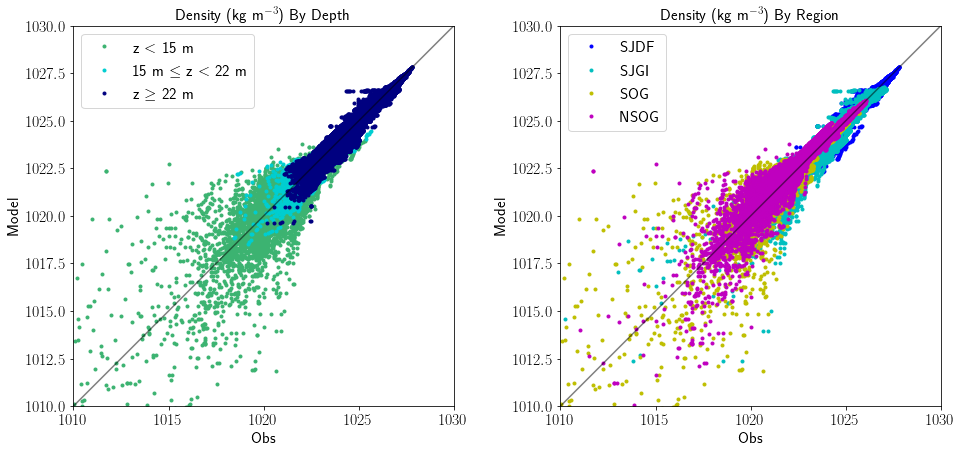

In [22]:
fig, ax = plt.subplots(1,2,figsize = (16,7))
ps,l=byDepth(ax[0],obsvar,modvar,(1010,1030))
ax[0].set_title('Density (kg m$^{-3}$) By Depth')

ps,l=byRegion(ax[1],obsvar,modvar,(1010,1030))
ax[1].set_title('Density (kg m$^{-3}$) By Region');

Text(0.5, 1.0, 'Density (kg m$^{-3}$)')

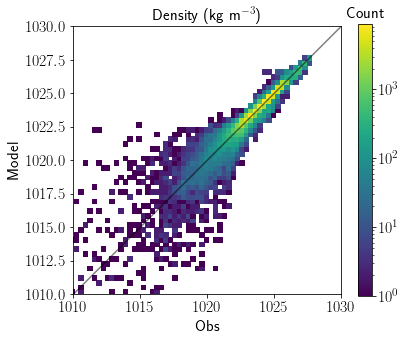

In [23]:
fig, ax = plt.subplots(1,1,figsize = (6,5))
a,b= densPlot(fig,ax,obsvar,modvar,(1010,1030))
ax.set_title('Density (kg m$^{-3}$)')

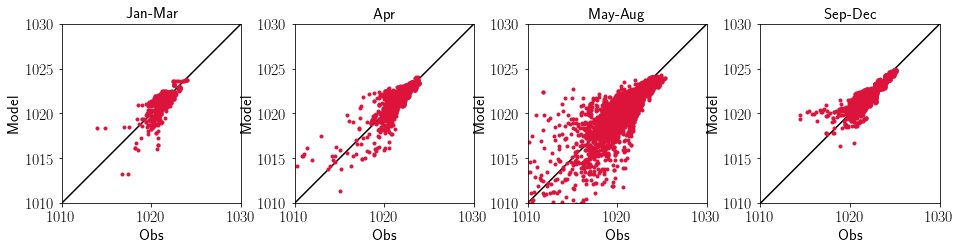

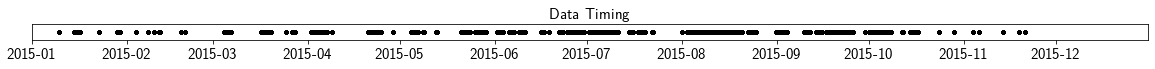

In [24]:
fig, ax = plt.subplots(1,4,figsize = (16,3.3))
bySeason(ax,obsvar,modvar,(1010,1030))
fig,ax=plt.subplots(1,1,figsize=(20,.3))
ax.plot(data.dtUTC,np.ones(np.shape(data.dtUTC)),'k.')
ax.set_xlim((dt.datetime(year,1,1),dt.datetime(year,12,31)))
ax.set_title('Data Timing')
ax.yaxis.set_visible(False)

### Temperature-Salinity by Region

In [25]:
def tsplot(ax,svar,tvar):
    limsS=(0,36)
    limsT=(5,25)
    ss,tt=np.meshgrid(np.linspace(limsS[0],limsS[1],20),np.linspace(limsT[0],limsT[1],20))
    rho=gsw.rho(ss,tt,np.zeros(np.shape(ss)))
    r=ax.contour(ss,tt,rho,colors='k')
    ps1=ax.plot(dJDF[svar],dJDF[tvar],'b.',label='SJDF')
    ps2=ax.plot(dSJGI[svar],dSJGI[tvar],'c.',label='SJGI')
    ps3=ax.plot(dSOG[svar],dSOG[tvar],'y.',label='SOG')
    ps4=ax.plot(dNSOG[svar],dNSOG[tvar],'m.',label='NSOG')
    l=ax.legend(handles=[ps1[0],ps2[0],ps3[0],ps4[0]],bbox_to_anchor=(1.55,1))
    ax.set_ylim(limsT)
    ax.set_xlim(limsS)
    ax.set_ylabel('$\Theta$ ($^{\circ}$C)')
    ax.set_xlabel('S$_A$ (g kg$^{-1}$)')
    ax.set_aspect((limsS[1]-limsS[0])/(limsT[1]-limsT[0]))
    return

Text(0.5, 1.0, 'Modelled')

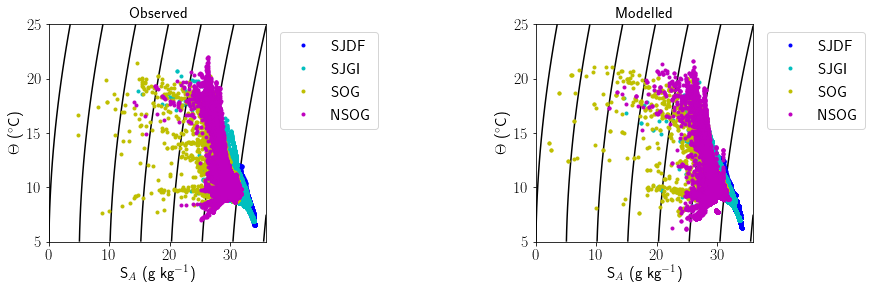

In [26]:
fig,ax=plt.subplots(1,2,figsize=(16,4))
tsplot(ax[0],'SA','CT')
ax[0].set_title('Observed')
tsplot(ax[1],'mod_vosaline','mod_votemper')
ax[1].set_title('Modelled')

### Profiles of T and S Residuals

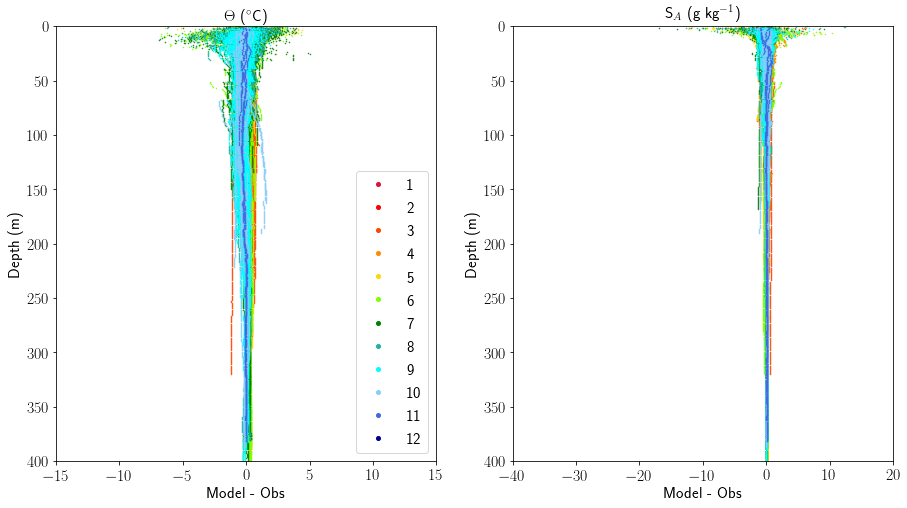

In [27]:
fig, ax = plt.subplots(1,2,figsize = (15,8))
cols=('crimson','red','orangered','darkorange','gold','chartreuse','green','lightseagreen','cyan',
      'lightskyblue','royalblue','darkblue','mediumslateblue','blueviolet',
      'darkmagenta','fuchsia','deeppink','pink')
start_date=dt.datetime(int(year),1,1)
p1=list()
for ii in range(0,int(np.ceil(365/31))):
    iii=(data.dtUTC>=(start_date+dt.timedelta(days=ii*31)))&(data.dtUTC<(start_date+dt.timedelta(days=(ii+1)*31)))
    ax[0].plot(data.loc[iii,['mod_votemper']].values-data.loc[iii,['CT']].values, data.loc[iii,['Z']].values, 
        '.', ms=1,color = cols[ii],label=str(ii))
    p1.append(ax[0].plot(-10000,-10000,'.', ms=8,color = cols[ii],label=str(ii)))
    ax[1].plot(data.loc[iii,['mod_vosaline']].values-data.loc[iii,['SA']].values, data.loc[iii,['Z']].values, 
        '.', ms=1,color = cols[ii],label=str(ii))
for axi in (ax[0],ax[1]):
    axi.set_ylim(400,0)
    axi.set_ylabel('Depth (m)')
ax[0].legend([el[0] for el in p1],[str(i) for i in range(1,len(p1)+1)],loc=4)
ax[0].set_xlabel('Model - Obs')
ax[1].set_xlabel('Model - Obs')
ax[0].set_xlim(-15,15)
ax[1].set_xlim(-40,20)
ax[0].set_title('$\Theta$ ($^{\circ}$C)')
ax[1].set_title('S$_A$ (g kg$^{-1}$)');

### Display All Stats

In [28]:
tbl,tdf=et.displayStats(statsDict[year],level='Variable',suborder=list(statsubs.keys()))
tbl